In [1]:
import pandas as pd
import numpy as np

from typing import List, Tuple, Union, Dict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
import geocoder
import os
import random

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import datetime
import re
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    GroupKFold,
)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.svm import SVR


In [2]:
class Config:
    train_path = "../input/train_v2.csv"
    test_path = "../input/test_v2.csv"
    sample_submission_path = "../input/sample_submission.csv"
    output_path = "../submission/"
    seed = 42
    n_splits = 5

In [3]:
random.seed(Config.seed)
os.environ["PYTHONHASHSEED"] = str(Config.seed)
np.random.seed(Config.seed)


In [4]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)


In [5]:
# 雪は花粉０そうなので0
df_train.loc[df_train["pollen_utsunomiya"] == -9998, "pollen_utsunomiya"] = 0
df_train.loc[df_train["pollen_chiba"] == -9998, "pollen_chiba"] = 0
df_train.loc[df_train["pollen_tokyo"] == -9998, "pollen_tokyo"] = 0


In [6]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


df_train = df_train.replace("欠測", np.nan)


df_train["precipitation_tokyo"] = df_train["precipitation_tokyo"].astype(float)
df_train["temperature_chiba"] = df_train["temperature_chiba"].astype(float)
df_train["temperature_tokyo"] = df_train["temperature_tokyo"].astype(float)

df_train["winddirection_chiba"] = df_train["winddirection_chiba"].fillna(0)
df_train["winddirection_chiba"] = df_train["winddirection_chiba"].astype(int)
df_train["winddirection_tokyo"] = df_train["winddirection_tokyo"].fillna(0)
df_train["winddirection_tokyo"] = df_train["winddirection_tokyo"].astype(int)

df_train["windspeed_chiba"] = df_train["windspeed_chiba"].astype(float)
df_train["windspeed_tokyo"] = df_train["windspeed_tokyo"].astype(float)

np.random.seed(Config.seed)
lgb_imp = IterativeImputer(
    estimator=LGBMRegressor(random_state=Config.seed, n_estimators=1000),
    max_iter=10,
    initial_strategy="mean",
    imputation_order="ascending",
    verbose=-1,
    random_state=Config.seed,
)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)


In [7]:
# 型がfloatになってしまっているので、もどす。
df_train[["winddirection_chiba", "winddirection_tokyo", "winddirection_utsunomiya"]] = (
    df_train[["winddirection_chiba", "winddirection_tokyo", "winddirection_utsunomiya"]]
    .round()
    .astype(int)
)
df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
] = df_train[
    [
        "precipitation_tokyo",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
].astype(float)
df_train["datetime"] = df_train["datetime"].astype(int)

# df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)


,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1,15,16,4.0,1.7,0.6,4.0,32.0,12.0


# Feature

In [8]:
# 時間
def to_datetime(time: datetime.datetime) -> datetime.datetime:
    time = str(time)
    try:
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
    except ValueError:
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, "%Y%m%d%H")
        time += datetime.timedelta(hours=1)
    return time


def time_feat(df: pd.DataFrame) -> pd.DataFrame:
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df["year"] = df["datetime_dt"].dt.year
    df["month"] = df["datetime_dt"].dt.month
    df["day"] = df["datetime_dt"].dt.day
    df["hour"] = df["datetime_dt"].dt.hour
    df["hour_sin"] = np.sin(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["hour_cos"] = np.cos(df["datetime_dt"].dt.hour * (2 * np.pi / (24 + 1)))
    df["weekday"] = df["datetime_dt"].dt.weekday
    df["day_of_year"] = df["datetime_dt"].dt.dayofyear
    
    #df["day_sin"] = np.sin(df["day_of_year"] * (2 * np.pi / (365 + 1)))
    #df["day_cos"] = np.cos(df["day_of_year"] * (2 * np.pi / (365 + 1)))

    # df["month_sin"] = np.sin(df["month"] * (2 * np.pi / (12 + 1)))
    # df["month_cos"] = np.cos(df["month"] * (2 * np.pi / (12 + 1)))

    # df["day_sin_sum_hour_sin"] = df["day_sin"] + df["hour_sin"]
    # df["day_cos_sum_hour_cos"] = df["day_sin"] + df["hour_cos"]

    # df["day_sin_sum_hour_sin_sum_month_sin"] = (
    #     df["day_sin"] + df["hour_sin"] + df["month_sin"]
    # )
    # df["day_cos_sum_hour_cos_sum_month_cos"] = (
    #     df["day_sin"] + df["hour_cos"] + df["month_cos"]
    # )

    # df["hour_sin_sum_month_sin"] = df["hour_sin"] + df["month_sin"]
    # df["hour_cos_sum_month_cos"] = df["hour_cos"] + df["month_cos"]

    # df["day_sin_mult_hour"] = df["day_sin"] * (1 + df["hour"] / 24)
    # df["day_cos_mult_hour"] = df["day_cos"] * (1 + df["hour"] / 24)

    # df["day_sin_mult_hour_mult_month"] = (
    #     df["day_sin"] * (1 + df["hour"] / 24) * (1 + df["month"] / 13)
    # )
    # df["day_cos_mult_hour_mult_month"] = (
    #     df["day_cos"] * (1 + df["hour"] / 24) * (1 + df["month"] / 13)
    # )

    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df: pd.DataFrame, feat: List[str], group: str) -> pd.DataFrame:
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。

    for lag in [1, 2, 3, 4, 5]:
        # for lag in list(range(1, 25)):
        # shift
        outputs.append(grp_df[feat].shift(lag).add_prefix(f"shift{lag}_"))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f"diff{lag}_"))

    # rolling
    windows = [3] + [i * 24 for i in range(1, 3)]
    #windows = [3] + [i * 24 for i in range(1, 10)]
    for window in windows:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f"rolling{window}_mean_")
        outputs.append(tmp_df.reset_index(drop=True))

    _df = pd.concat(outputs, axis=1)
    return _df


def add_lag_feat_one_year(df: pd.DataFrame, feat: List[str]) -> pd.DataFrame:
    outputs = [df]
    prefix = "shift_one_year_"
    outputs.append(df[feat].shift(3600).add_prefix(prefix))

    df = pd.concat(outputs, axis=1)
    outputs = [df]
    cols = [f"{prefix}{col}" for col in feat]

    for window in [3] + [i * 24 for i in range(1, 10)]:
        outputs.append(
            df[cols].rolling(window, min_periods=1).mean().add_prefix(f"roll_{window}_")
        )

    df = pd.concat(outputs, axis=1)
    return df


# 集計特徴
def additional_encoding(
    train: pd.DataFrame, test: pd.DataFrame, cat_col: List[str], num_col: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    trdf = train.copy()
    tedf = test.copy()

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf["month"] == 4) & (trdf["day"] < 15)][ccol].value_counts()
        trdf[f"ce_{ccol}"] = trdf[ccol].map(encoder)
        tedf[f"ce_{ccol}"] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ["mean", "std", "min", "max"]
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df["abs_mean"] = np.abs(agg_df["mean"])
            agg_df["min_max"] = agg_df["min"] * agg_df["max"]
            agg_df.columns = [f"{ccol}_{c}" for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how="left")
            tedf = tedf.merge(agg_df, on=ccol, how="left")

    return trdf, tedf


def add_wind_direction_one_hot(df: pd.DataFrame) -> pd.DataFrame:

    cols = [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]

    num_wind_direction = 17

    dfs = []
    for col in cols:
        data = {f"{col}_one_hot_{i}": [] for i in range(num_wind_direction)}
        for x in df[col].astype(int):
            for i in range(num_wind_direction):
                if x == i:
                    data[f"{col}_one_hot_{i}"].append(1)
                else:
                    data[f"{col}_one_hot_{i}"].append(0)

        _df = pd.DataFrame(data)
        dfs.append(_df)

    return pd.concat([df] + dfs, axis=1)


def add_wind_direction_to_cos_sin(df: pd.DataFrame) -> pd.DataFrame:
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    1：北北東
    2：北東
    3：東北東
    4：東
    5：東南東
    6：南東
    7：南南東
    8：南
    9：南南西
    10：南西
    11：西南西
    12：西
    13：西北西
    14：北西
    15：北北西
    16：北

    """
    df_origin = df.copy()

    direction_map = {
        1: 13,
        2: 14,
        3: 15,
        4: 0,
        5: 1,
        6: 2,
        7: 3,
        8: 4,
        9: 5,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
    }

    pref_list = ["utsunomiya", "tokyo", "chiba"]

    for col in [
        "winddirection_utsunomiya",
        "winddirection_tokyo",
        "winddirection_chiba",
    ]:

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        # _df[col] = _df[col] - 1  # 1 ~ 16 なので 0 ~ 15に変換
        _df[col] = _df[col].apply(lambda x: direction_map[x])

        _df[f"{col}_cos"] = np.cos(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df[f"{col}_sin"] = np.sin(2 * np.pi * _df[col] / (_df[col].max() + 1))
        _df = _df.drop(col, axis=1)
    
    df_origin = df_origin.reset_index()
    df_origin = df_origin.merge(_df, on="index", how="left")
    df_origin = df_origin.drop("index", axis=1)

    return df_origin


def remove_noise(
    df: pd.DataFrame, window_length: int, polyorder: int = 2, overwite: bool = False
) -> pd.DataFrame:
    _df = df.copy()
    cols = [
        "precipitation_utsunomiya",
        "precipitation_chiba",
        "precipitation_tokyo",
        "temperature_utsunomiya",
        "temperature_chiba",
        "temperature_tokyo",
        "windspeed_utsunomiya",
        "windspeed_chiba",
        "windspeed_tokyo",
    ]
    for col in cols:
        np.random.seed(Config.seed)
        # _df[f"{col}_smooth_{window_length}"] = savgol_filter(_df[col])
        if overwite:
            _df[col] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
        else:
            _df[f"{col}_smooth_{window_length}"] = savgol_filter(
                _df[col], window_length=window_length, polyorder=polyorder
            )
            _df.loc[
                _df[f"{col}_smooth_{window_length}"] < 0,
                f"{col}_smooth_{window_length}",
            ] = 0

    return _df


def add_precipitation_zero_count_feat(df: pd.DataFrame) -> pd.DataFrame:
    # https://comp.probspace.com/competitions/pollen_counts/discussions/saru_da_mon-Post5943fd8142f960c070d7

    th = 0.5
    for pref in ["utsunomiya", "chiba", "tokyo"]:
        count_list_all = []
        for year in [2017, 2018, 2019, 2020]:
            _df = df[df.year == year].reset_index(drop=True)
            count_list_by_year = []
            n_count = 0
            for e in _df[f"precipitation_{pref}"]:
                if e < th:
                    n_count += 1
                else:
                    n_count = 0
                count_list_by_year.append(np.log1p(n_count))
            count_list_all.extend(count_list_by_year)
        df[f"precipitation_{pref}_count_{th}_2"] = count_list_all

    return df


def temperature_flag(df: pd.DataFrame) -> pd.DataFrame:
    # https://www.allegra.jp/hayfever/how_predict.html
    # 気温が30℃を超え日照時間が多いと花芽が多く作られ、翌年春の花粉飛散量は多くなります。
    # 逆に最高気温が25℃程度にしかならないいわゆる「冷夏」では、木は花芽ではなく枝を伸ばすことに注力するため、
    # 翌年春の花粉飛散量は少なくなります。

    # 30度超えたかのフラグ
    cols = ["temperature_utsunomiya", "temperature_chiba", "temperature_tokyo"]

    for col in cols:
        for th in [20, 25, 30]:
            df[f"{col}_over_{th}"] = (df[col] > th).astype(int)

    return df


def add_sekisan_ondo(
    df: pd.DataFrame,
    cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ],
) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく

    dfs = []
    for year in [2017, 2018, 2019, 2020]:
        _df = df[df.year == year].copy()
        _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df_temp_mean = _df[["ymd", col]].groupby("ymd").max().reset_index()
            _df_temp_mean = _df_temp_mean.rename(columns={col: f"{col}_daily_max"})
            _df_temp_mean[f"sekisan_ondo_{col}"] = _df_temp_mean[
                f"{col}_daily_max"
            ].cumsum()
            _df_temp_mean = _df_temp_mean.drop(f"{col}_daily_max", axis=1)            
            _df = _df.merge(_df_temp_mean, on="ymd", how="inner")
            

        _df = _df.drop("ymd", axis=1)
        dfs.append(_df)

    _df = pd.concat(dfs)

    return _df

def add_diff_max_min_day(
    df: pd.DataFrame,
    cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
        "precipitation_utsunomiya",
        "precipitation_tokyo",
        "precipitation_chiba",
    ],
) -> pd.DataFrame:    

    dfs = []
    for year in [2017, 2018, 2019, 2020]:
        _df = df[df.year == year].copy()
        _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df_temp_max = _df[["ymd", col]].groupby("ymd").max().reset_index()
            _df_temp_max = _df_temp_max.rename(columns={col: f"{col}_daily_max_"})            
            _df_temp_min = _df[["ymd", col]].groupby("ymd").max().reset_index()
            _df_temp_min = _df_temp_min.rename(columns={col: f"{col}_daily_min_"})            
            
            _df = _df.merge(_df_temp_max, on="ymd", how="inner")
            _df[f"{col}_diff-max"] = _df[f"{col}_daily_max_"] - _df[col]

            _df = _df.merge(_df_temp_min, on="ymd", how="inner")
            _df[f"{col}_diff-min"] = _df[f"{col}_daily_min_"] - _df[col]

        _df = _df.drop("ymd", axis=1)
        dfs.append(_df)

    _df = pd.concat(dfs)

    return _df


def add_sekisan_ondo2(
    df: pd.DataFrame,
    cols: List[str] = [
        "temperature_utsunomiya",
        "temperature_tokyo",
        "temperature_chiba",
    ],
) -> pd.DataFrame:
    # https://hp.otenki.com/401/
    # 1/1からの毎日の温度の平均を和を算出していく

    dfs = []
    for year in [2017, 2018, 2019, 2020]:
        _df = df[df.year == year].reset_index(drop=True).copy()
        # _df["ymd"] = _df["datetime_dt"].apply(lambda x: x.strftime("%Y%m%d"))

        for col in cols:
            _df.loc[_df[col] < 0, col] = 0
            s = _df[col].sum()
            _df[f"sekisan_ondo_{col}_2"] = _df[col].cumsum()
            # _df[f"sekisan_ondo_{col}_2_ratio"] = _df[f"sekisan_ondo_{col}_2"] / s
        dfs.append(_df)

    _df = pd.concat(dfs)

    return _df


def temperature_decompose(df: pd.DataFrame) -> pd.DataFrame:
    from statsmodels.tsa.seasonal import STL    

    _df = df.copy()
    np.random.seed(Config.seed)
    for col in ["temperature_tokyo", "temperature_utsunomiya", "temperature_chiba"]:        
        np.random.seed(Config.seed)
        res = STL(_df[col], period=24).fit()
        _df[f"{col}_decompose_trend"] = res.trend
        _df[f"{col}_decompose_seasonal"] = res.seasonal
        _df[f"{col}_decompose_resid"] = res.resid
        _df[f"{col}_decompose_minus_trend"] = _df[col] - _df[f"{col}_decompose_trend"]

    return _df


def add_precipitation_mult_month(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    for col in ["precipitation_tokyo", "precipitation_chiba", "precipitation_tokyo"]:
        _df[f"{col}_mult_month"] = _df[col] * (1 / _df["month"])

    return _df


def make_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = time_feat(df)

    # 降水量カウント
    df = add_precipitation_zero_count_feat(df)

    #df = remove_noise(df, window_length=7, overwite=False)
    #df = remove_noise(df, window_length=13, overwite=False)
    #df = remove_noise(df, window_length=25, overwite=False)
    # df = remove_noise(df, window_length=(24 * 7 + 1), overwite=False)

    # ラグ特徴の追加
    # feat = [
    #     "precipitation_utsunomiya",
    #     "precipitation_chiba",
    #     "precipitation_tokyo",
    #     "temperature_utsunomiya",
    #     "temperature_chiba",
    #     "temperature_tokyo",
    #     "windspeed_utsunomiya",
    #     "windspeed_chiba",
    #     "windspeed_tokyo",
    # ]
    # df = add_lag_feat(df, feat, "year")

    # # ノイズ除去でラグ
    # feat_smooth = [col for col in df.columns if "_smooth" in col]
    # df = add_lag_feat(df, feat_smooth, "year")

    # # 風 one-hot
    # #df = add_wind_direction_one_hot(df)

    # # 風
    # df = add_wind_direction_to_cos_sin(df)
    # feat_window = [
    #     f
    #     for f in df.columns
    #     if ("cos_mult_window_speed" in f)
    #     or ("sin_mult_window_speed" in f)
    #     or ("mult_precipitation" in f)
    # ]
    # df = add_lag_feat(df, feat_window, "year")

    # # 積算温度
    # df = add_sekisan_ondo(df)
    # # df = add_sekisan_ondo2(df) #mlp dowen

    # # 1年ラグ
    # df = add_lag_feat_one_year(df, feat)

    # # over ->効かない
    # #df = temperature_flag(df)
    # #temp_over_feat = [f for f in df.columns if "_over_" in f]
    # #df = add_lag_feat_one_year(df, temp_over_feat)

    # # decompose
    # df = temperature_decompose(df.reset_index(drop=True))
    # decompose_feat = [f for f in df.columns if "_decompose_" in f]
    # df = add_lag_feat(df, decompose_feat, "year")


    #df = add_diff_max_min_day(df)

    # df = add_precipitation_mult_month(df)
    df = df.drop(
        [
            "winddirection_utsunomiya",
            "winddirection_tokyo",
            "winddirection_chiba",
        ],
        axis=1,
    )
    
    # df = add_lag_feat_one_year(df, feat_smooth_7)
    # df = add_lag_feat_one_year(df, feat_smooth_13)
    # df = add_lag_feat_one_year(df, feat_smooth_25)
    # df = add_lag_feat_one_year(df, feat_window)

    return df


In [9]:
df_train.shape, df_test.shape


((12240, 16), (336, 16))

In [10]:
df_test["pollen_utsunomiya"] = -1
df_test["pollen_chiba"] = -1
df_test["pollen_tokyo"] = -1

_df_tmp = pd.concat([df_train, df_test]).reset_index(drop=True)

_df_feat = make_feature(_df_tmp)

_df = _df_feat[_df_feat["pollen_utsunomiya"] != -1].reset_index(drop=True)
_df_test = _df_feat[_df_feat["pollen_utsunomiya"] == -1].reset_index(drop=True)

# _df = _df.reset_index(drop=True)
# _df_test = _df_test.reset_index(drop=True)

_df_test = _df_test.drop(["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"], axis=1)


In [11]:
_df.shape, _df_test.shape


((12240, 25), (336, 22))

In [12]:
_df.columns

Index(['datetime', 'precipitation_utsunomiya', 'precipitation_chiba',
       'precipitation_tokyo', 'temperature_utsunomiya', 'temperature_chiba',
       'temperature_tokyo', 'windspeed_utsunomiya', 'windspeed_chiba',
       'windspeed_tokyo', 'pollen_utsunomiya', 'pollen_chiba', 'pollen_tokyo',
       'datetime_dt', 'year', 'month', 'day', 'hour', 'hour_sin', 'hour_cos',
       'weekday', 'day_of_year', 'precipitation_utsunomiya_count_0.5_2',
       'precipitation_chiba_count_0.5_2', 'precipitation_tokyo_count_0.5_2'],
      dtype='object')

In [13]:
q_ut, q_tk, q_cb = 20, 20, 20
# q_ut, q_tk, q_cb = 36, 24, 36
# q_ut, q_tk, q_cb = 16, 16, 16
# q_ut, q_tk, q_cb = 60, 24, 36

# try
# q_ut, q_tk, q_cb = 20, 20, 20


In [14]:
def train_lightgbm_with_cv_log(
    _df: pd.DataFrame,  # 学習データ
    df_test: pd.DataFrame,  # テストデータ
    target_label: str,  # target label
    label_cols: List[str] = [
        "pollen_utsunomiya",
        "pollen_chiba",
        "pollen_tokyo",
    ],
    unused_label: List[str] = [
        "datetime",
        "datetime_dt",
        "year",
    ],
    plot: bool = False,    
) -> Union[np.array, List[np.float], pd.DataFrame]:

    print(f"========={target_label}==========")    

    _df = _df.copy()
    df_test = df_test.copy()

    cols = [col for col in _df.columns if col not in label_cols + unused_label]

    # folds = TimeSeriesSplit(n_splits=Config.n_splits)
    folds = KFold(n_splits=Config.n_splits, random_state=Config.seed)
    scores = []
    prediction = np.zeros(len(df_test))
    imps_list = []

    # _df = _df[_df[label] >=0].reset_index(drop=True)
    # _df = _df[_df[label] <= qth].reset_index(drop=True)
    # _df = _df[(_df["month"] == 4) | (_df["month"] == 5) | (_df["month"] == 6)].reset_index()

    _val_scores = np.zeros(len(_df))

    for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
        print(f"=====fold {fold}=======")
        np.random.seed(Config.seed)
        
        df_train = _df.iloc[train_idx].reset_index(drop=True)
        df_val = _df.iloc[val_idx].reset_index(drop=True)

        print("train shape", df_train.shape, "test shape", df_val.shape)

        model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)

        label = target_label

        # # データがv2になってから花粉飛散量がマイナスのがある。削除する。
        # df_train = df_train[df_train[label] >= 0].reset_index(drop=True)
        # df_val = df_val[df_val[label] >= 0].reset_index(drop=True)

        # df_train = df_train[df_train[label] <= qth].reset_index(drop=True)
        # df_val = df_val[df_val[label] <= qth].reset_index(drop=True)

        # df_train = df_train[(df_train["month"] == 4) | (df_train["month"] == 5) | (df_train["month"] == 3)].reset_index(drop=True)
        # df_val = df_val[(df_val["month"] == 4) | (df_val["month"] == 5)|  (df_val["month"] == 3)].reset_index(drop=True)
        #print(df_train.shape)

        model.fit(
            df_train[cols],
            np.log1p(df_train[label] /4),
            eval_set=(df_val[cols], np.log1p(df_val[label] / 4)),
            eval_metric="fair",
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=1000, verbose=False
                ),  # early_stopping用コールバック関数
                lgb.log_evaluation(0),
            ],  # コマンドライン出力用コールバック関数
        )

        # validation
        val_pred = model.predict(df_val[cols], num_iteration=model.best_iteration_)
        val_pred = np.expm1(val_pred).round()*4
        val_score = mean_absolute_error(df_val[label], val_pred)
        scores.append(val_score)
        print("score =", val_score)

        print(_val_scores.shape, val_pred.shape, val_idx.shape)
        _val_scores[val_idx] = val_pred


        if plot:
            _df_val = df_val.copy()
            _df_val["pred"] = val_pred
            plt.figure(figsize=(20, 10))
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y=label)
            ax = sns.lineplot(data=_df_val, x="datetime_dt", y="pred")
            plt.show()

        _pred = model.predict(df_test[cols], num_iteration=model.best_iteration_)
        _pred = np.expm1(_pred).round()*4
        prediction += _pred / Config.n_splits
        prediction = np.where(prediction < 0, 0, prediction)

        imps = model.feature_importances_
        imps_list.append(imps)

    imps = np.mean(imps_list, axis=0)
    df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
    df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

    return prediction, scores, df_imps, _val_scores


# Utsunomiya pred

In [15]:
# unused_cols = [
#     col
#     for col in _df.columns
#     if (("temperature_utsunomiya" in col) and ("decompose" not in col))
# ]

# precipitation は入れた方がよい


In [16]:
label = "pollen_utsunomiya"
_df_ut = _df[_df[label] >=0].reset_index(drop=True)
_df_ut = _df_ut[_df_ut[label] <= q_ut].reset_index(drop=True)
_df_ut = _df_ut[(_df_ut["month"] == 4) | (_df_ut["month"] == 5) | (_df_ut["month"] == 6)].reset_index(drop=True)


utsunomiya_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
    _df_ut,
    _df_test,
    target_label=label,
    plot=False,    
    #unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
    unused_label=["datetime", "datetime_dt"] #+ unused_cols,
)
for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


# https://static.signate.jp/competitions/624/summaries/3%E4%BD%8D_yayaya%E6%A7%98.pdf
# _df_ut["diff_pred_target"] = np.abs(_val_scores - _df_ut[label])

# diff_pred_target_test, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df_ut,
#     _df_test,
#     target_label="diff_pred_target",
#     plot=False,    
#     unused_label=["year", "datetime", "datetime_dt", "diff_pred_target"] 
# )
# _df_test_ut = _df_test.copy()
# _df_test_ut["diff_pred_target"] = diff_pred_target_test


# utsunomiya_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df_ut,
#     _df_test_ut,
#     target_label=label,
#     plot=False,    
#     unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
# )


for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

utsunomiya_score = np.mean(scores)


=========pollen_utsunomiya==========
=====fold 0=======
train shape (3185, 25) test shape (797, 25)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


score = 3.633626097867001
(3982,) (797,) (797,)
=====fold 1=======
train shape (3185, 25) test shape (797, 25)
score = 1.5457967377666249
(3982,) (797,) (797,)
=====fold 2=======
train shape (3186, 25) test shape (796, 25)
score = 2.2261306532663316
(3982,) (796,) (796,)
=====fold 3=======
train shape (3186, 25) test shape (796, 25)
score = 2.8391959798994977
(3982,) (796,) (796,)
=====fold 4=======
train shape (3186, 25) test shape (796, 25)
score = 0.47738693467336685
(3982,) (796,) (796,)
 fold_0 mae: 3.633626097867001
 fold_1 mae: 1.5457967377666249
 fold_2 mae: 2.2261306532663316
 fold_3 mae: 2.8391959798994977
 fold_4 mae: 0.47738693467336685
mean: 2.1444272806945643
 fold_0 mae: 3.633626097867001
 fold_1 mae: 1.5457967377666249
 fold_2 mae: 2.2261306532663316
 fold_3 mae: 2.8391959798994977
 fold_4 mae: 0.47738693467336685
mean: 2.1444272806945643


In [17]:
# utsunomiya_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df,
#     _df_test,
#     target_label="pollen_utsunomiya",
#     plot=False,
#     qth=q_ut,
#     unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
# )

# for i, score in enumerate(scores):
#     print(f" fold_{i} mae: {score}")
# print(f"mean {np.mean(scores)}")

# utsunomiya_score = np.mean(scores)

# # [ 2448  2449  2450 ... 12237 12238 12239]


In [18]:
df_imps.to_csv("fea_imp/utsunomiya_imp.csv", index=None)

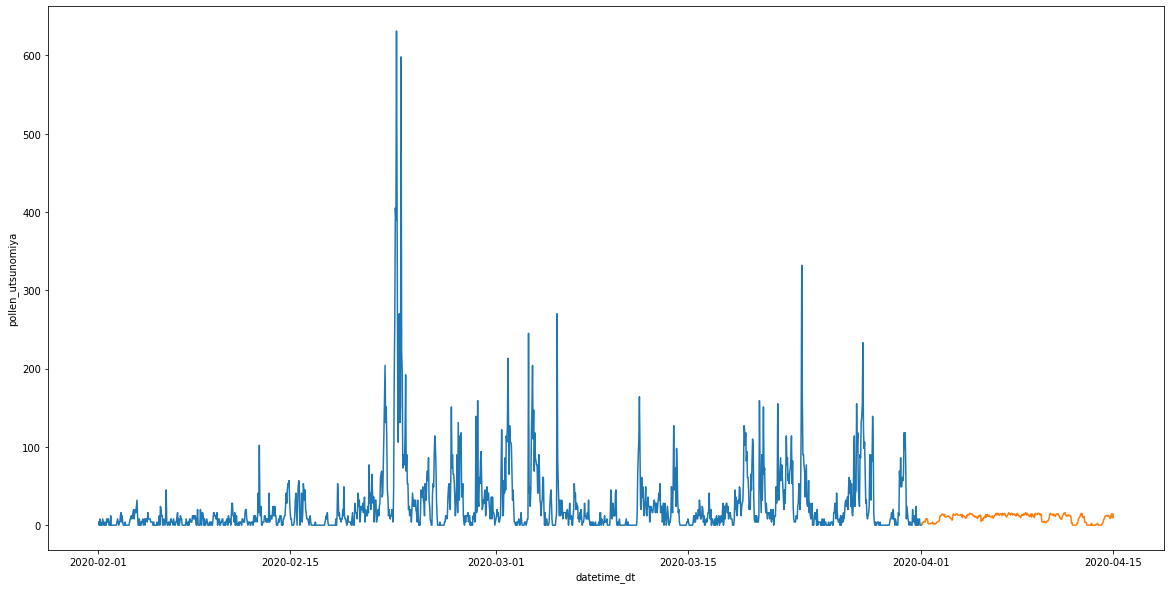

In [19]:
__df_test = _df_test.copy()
__df_test["pollen_utsunomiya"] = utsunomiya_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year == 2020], x="datetime_dt", y="pollen_utsunomiya")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_utsunomiya")


<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

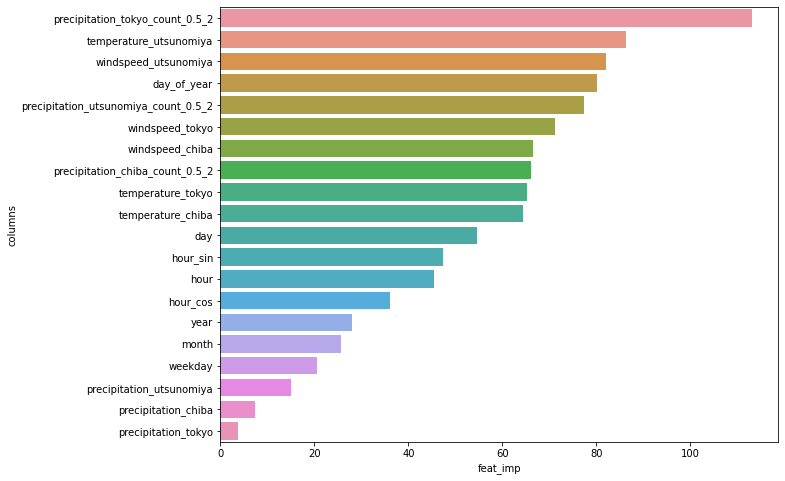

In [20]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


In [21]:
df_imps.tail(10)

,columns,feat_imp
10,day,54.6
11,hour_sin,47.4
12,hour,45.4
13,hour_cos,36.0
14,year,28.0
15,month,25.6
16,weekday,20.6
17,precipitation_utsunomiya,15.0
18,precipitation_chiba,7.4
19,precipitation_tokyo,3.8


# Tokyo pred

In [22]:
# unused_cols = [
#     col
#     for col in _df.columns
#     if ("temperature_tokyo" in col) and ("decompose" not in col)
# ]


In [23]:
label = "pollen_tokyo"
_df_tk = _df[_df[label] >=0].reset_index(drop=True)
_df_tk = _df_tk[_df_tk[label] <= q_tk].reset_index(drop=True)
_df_tk = _df_tk[(_df_tk["month"] == 4) | (_df_tk["month"] == 5) | (_df_tk["month"] == 6)].reset_index(drop=True)


tokyo_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
    _df_tk,
    _df_test,
    target_label=label,
    plot=False,
    #qth=q_tk,
    #unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
    unused_label=["datetime", "datetime_dt"] #+ unused_cols,
)
for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


# https://static.signate.jp/competitions/624/summaries/3%E4%BD%8D_yayaya%E6%A7%98.pdf
# _df_tk["diff_pred_target"] = np.abs(_val_scores - _df_tk["pollen_tokyo"])

# diff_pred_target_test, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df_tk,
#     _df_test,
#     target_label="diff_pred_target",
#     plot=False,
#     #qth=q_tk,
#     unused_label=["year", "datetime", "datetime_dt", "diff_pred_target"] 
# )
# _df_test_tk = _df_test.copy()
# _df_test_tk["diff_pred_target"] = diff_pred_target_test


# tokyo_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df_tk,
#     _df_test_tk,
#     target_label="pollen_tokyo",
#     plot=False,
#     #qth=q_tk,
#     unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
# )



for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

tokyo_score = np.mean(scores)


=========pollen_tokyo==========
=====fold 0=======
train shape (4172, 25) test shape (1043, 25)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


score = 3.9846596356663473
(5215,) (1043,) (1043,)
=====fold 1=======
train shape (4172, 25) test shape (1043, 25)
score = 2.8149568552253115
(5215,) (1043,) (1043,)
=====fold 2=======
train shape (4172, 25) test shape (1043, 25)
score = 1.7641418983700863
(5215,) (1043,) (1043,)
=====fold 3=======
train shape (4172, 25) test shape (1043, 25)
score = 3.884947267497603
(5215,) (1043,) (1043,)
=====fold 4=======
train shape (4172, 25) test shape (1043, 25)
score = 1.2732502396931926
(5215,) (1043,) (1043,)
 fold_0 mae: 3.9846596356663473
 fold_1 mae: 2.8149568552253115
 fold_2 mae: 1.7641418983700863
 fold_3 mae: 3.884947267497603
 fold_4 mae: 1.2732502396931926
mean: 2.744391179290508
 fold_0 mae: 3.9846596356663473
 fold_1 mae: 2.8149568552253115
 fold_2 mae: 1.7641418983700863
 fold_3 mae: 3.884947267497603
 fold_4 mae: 1.2732502396931926
mean: 2.744391179290508


In [24]:
df_imps.to_csv("fea_imp/tokyo_imp.csv", index=None)

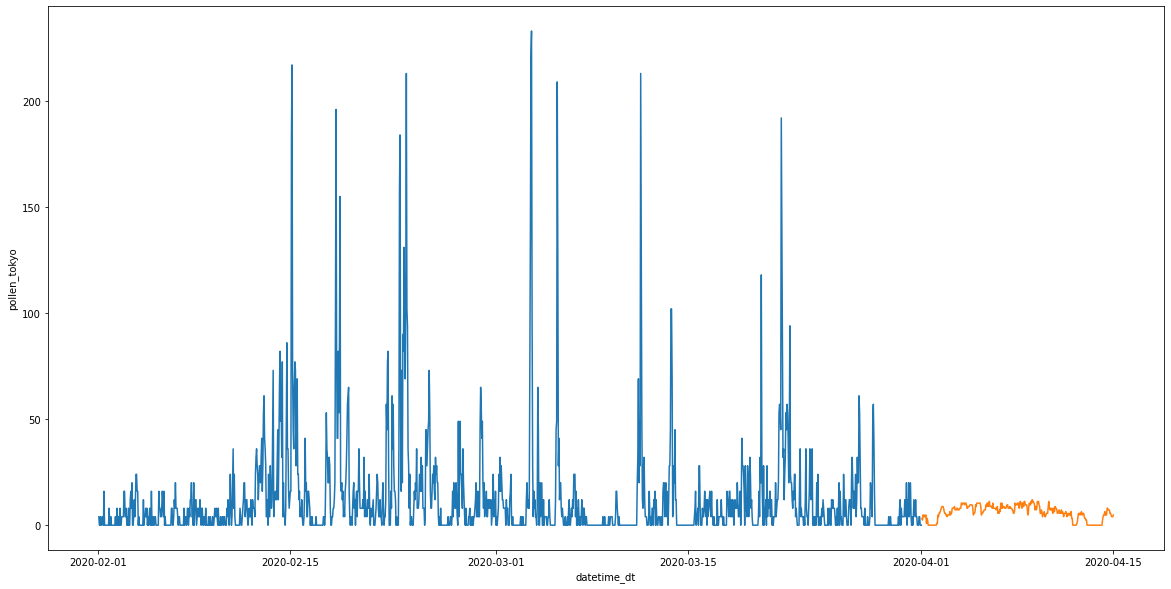

In [25]:
__df_test = _df_test.copy()
__df_test["pollen_tokyo"] = tokyo_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year == 2020], x="datetime_dt", y="pollen_tokyo")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_tokyo")


<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

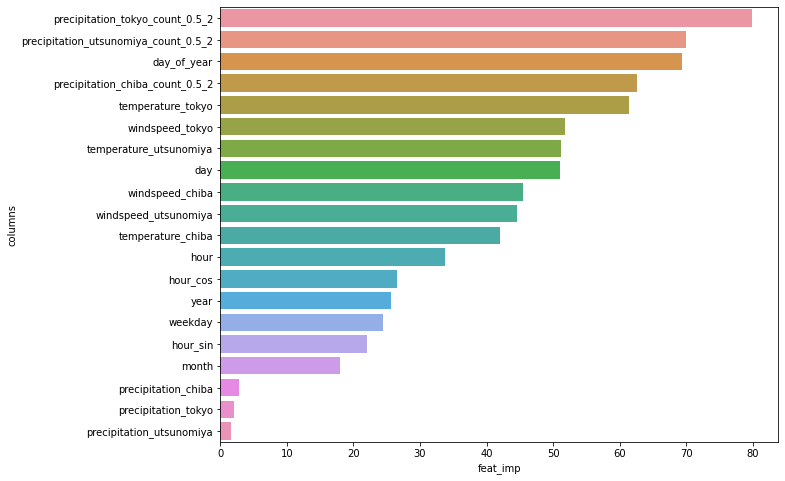

In [26]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


# Chiba prediciton

In [27]:
# unused_cols = [col for col in _df.columns if ("temperature_chiba" in col) and ("decompose" not in col)]


In [28]:
label = "pollen_chiba"
_df_cb = _df[_df[label] >=0].reset_index(drop=True)
_df_cb = _df_cb[_df_cb[label] <= q_cb].reset_index(drop=True)
_df_cb = _df_cb[(_df_cb["month"] == 4) | (_df_cb["month"] == 5) | (_df_cb["month"] == 6)].reset_index(drop=True)


chiba_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
    _df_cb,
    _df_test,
    target_label=label,
    plot=False,    
    #unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
    unused_label=["datetime", "datetime_dt"] #+ unused_cols,
)
for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")


# https://static.signate.jp/competitions/624/summaries/3%E4%BD%8D_yayaya%E6%A7%98.pdf
# _df_cb["diff_pred_target"] = np.abs(_val_scores - _df_cb[label])

# diff_pred_target_test, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df_cb,
#     _df_test,
#     target_label="diff_pred_target",
#     plot=False,    
#     unused_label=["year", "datetime", "datetime_dt", "diff_pred_target"] 
# )
# _df_test_cb = _df_test.copy()
# _df_test_cb["diff_pred_target"] = diff_pred_target_test


# chiba_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df_cb,
#     _df_test_cb,
#     target_label=label,
#     plot=False,    
#     unused_label=["year", "datetime", "datetime_dt"] #+ unused_cols,
# )


for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")
print(f"mean: {np.mean(scores)}")

chiba_score = np.mean(scores)

=========pollen_chiba==========
=====fold 0=======
train shape (4204, 25) test shape (1051, 25)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


score = 4.738344433872502
(5255,) (1051,) (1051,)
=====fold 1=======
train shape (4204, 25) test shape (1051, 25)
score = 1.9752616555661275
(5255,) (1051,) (1051,)
=====fold 2=======
train shape (4204, 25) test shape (1051, 25)
score = 3.018078020932445
(5255,) (1051,) (1051,)
=====fold 3=======
train shape (4204, 25) test shape (1051, 25)
score = 3.075166508087536
(5255,) (1051,) (1051,)
=====fold 4=======
train shape (4204, 25) test shape (1051, 25)
score = 1.632730732635585
(5255,) (1051,) (1051,)
 fold_0 mae: 4.738344433872502
 fold_1 mae: 1.9752616555661275
 fold_2 mae: 3.018078020932445
 fold_3 mae: 3.075166508087536
 fold_4 mae: 1.632730732635585
mean: 2.887916270218839
 fold_0 mae: 4.738344433872502
 fold_1 mae: 1.9752616555661275
 fold_2 mae: 3.018078020932445
 fold_3 mae: 3.075166508087536
 fold_4 mae: 1.632730732635585
mean: 2.887916270218839


In [29]:
# chiba_prediction, scores, df_imps, _val_scores = train_lightgbm_with_cv_log(
#     _df,
#     _df_test,
#     target_label="pollen_chiba",
#     plot=False,
#     qth=q_cb,
#     unused_label=["year", "datetime", "datetime_dt"] ,  # 
# )

# for i, score in enumerate(scores):
#     print(f" fold_{i} mae: {score}")
# print(f"mean: {np.mean(scores)}")


# chiba_score = np.mean(scores)


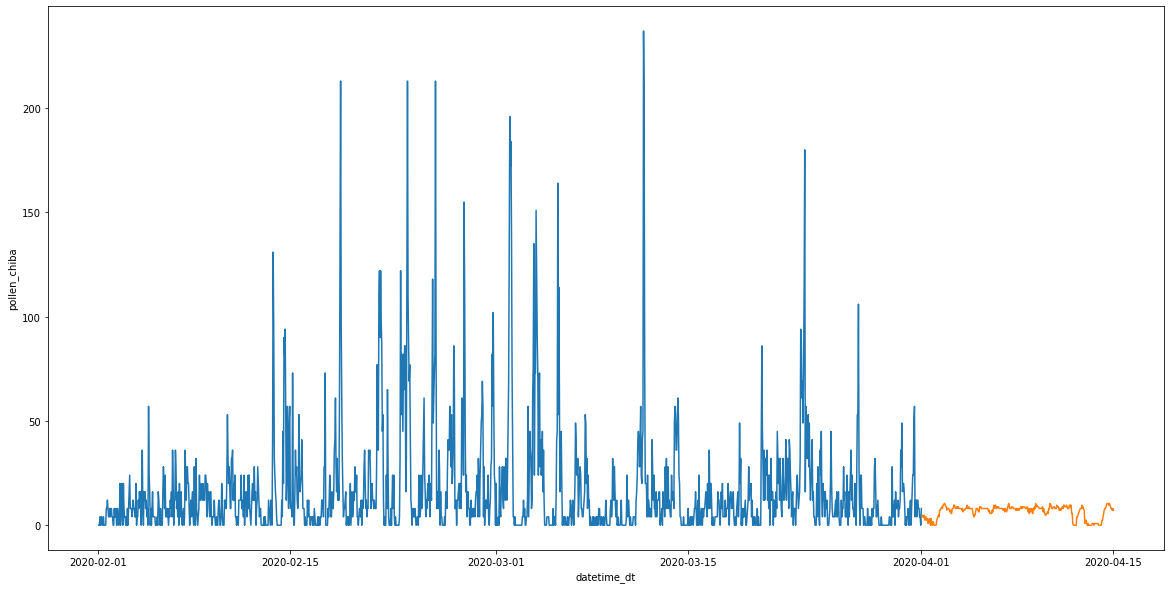

In [30]:
__df_test = _df_test.copy()
__df_test["pollen_chiba"] = chiba_prediction
plt.figure(figsize=(20, 10))
ax = sns.lineplot(data=_df[_df.year == 2020], x="datetime_dt", y="pollen_chiba")
ax = sns.lineplot(data=__df_test, x="datetime_dt", y="pollen_chiba")


<AxesSubplot:xlabel='feat_imp', ylabel='columns'>

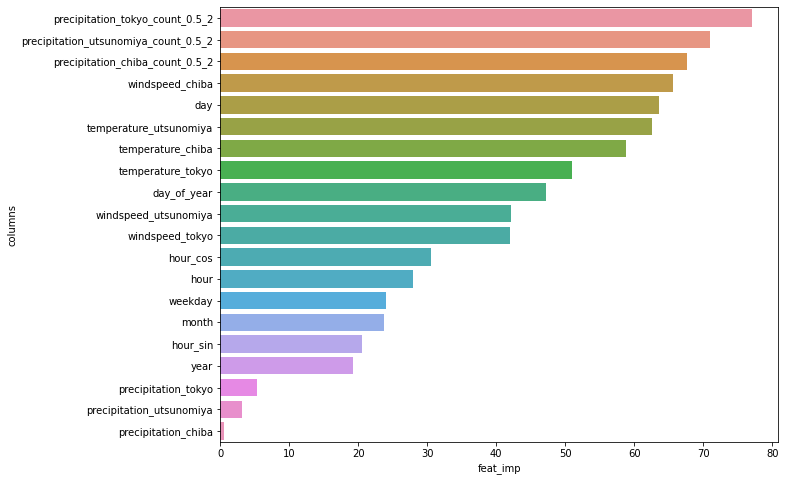

In [31]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")


In [32]:
df_imps[df_imps.feat_imp == 0 ]

,columns,feat_imp


In [33]:
os.makedirs("fea_imp", exist_ok=True)
df_imps.to_csv("fea_imp/chiba_imp.csv", index=None)

# submission

In [34]:
df_sub = _df_test[["datetime"]]


In [35]:
df_sub.loc[:, "pollen_utsunomiya"] = utsunomiya_prediction
df_sub.loc[:, "pollen_chiba"] = chiba_prediction
df_sub.loc[:, "pollen_tokyo"] = tokyo_prediction


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [36]:
df_sub.to_csv(f"sub.csv", index=None)


In [37]:
utsunomiya_score, tokyo_score, chiba_score, np.mean(
    [utsunomiya_score, tokyo_score, chiba_score]
)


(2.1444272806945643, 2.744391179290508, 2.887916270218839, 2.5922449100679708)

- (2.1665479215399457, 2.691466922339406, 2.8331113225499522, 2.563708722143101) 4で割って4倍する LB: 12.82488
- (2.223069842318023, 2.7985538649568302, 2.980598502400822, 2.667407403225225) yearを入れる LB: 12.64291
- (2.2552974229657274, 2.80020042665684, 3.002624539547793, 2.6860407963901203) round -> float
- (2.2585970292202355, 2.784442780465982, 3.0164557232057967, 2.6864985109640043) なんか直った
- (2.231501389832784, 2.7905356657360016, 2.9839403954501345, 2.6686591503396406) 乱数確認
- (2.2585970292202355, 2.784442780465982, 3.0164557232057967, 2.6864985109640043) ↓をはずす　LB: 	12.63943
- (1.8902552539723196, 1.9238658296096862, 2.3918798157476298, 2.068666966443212) targetと予測の差分を特徴量に入れる　LB: 12.66570
- (4.849750906965388, 4.7050786743344535, 4.804530606251727, 4.786453395850523) rollを増やす下がった
- (4.785758154050847, 4.719695234551823, 4.84878888848935, 4.784747425697341) 乱数固定できたっぽい
- (4.785758154050847, 4.719695234551823, 4.84878888848935, 4.784747425697341) 乱数確認
- (4.779522746668781, 4.703589033881497, 4.831507795860189, 4.7715398588034885) 乱数確認。ロジックは↓とおなじ
- (4.8674740481450645, 4.7122016034010725, 4.847491302606132, 4.80905565138409) 消す
- (4.785703395204035, 4.71808406277477, 4.839028069658818, 4.780938509212541) 不要な特徴量を消す 
- (4.899446226564631, 4.729779801585153, 4.8242340084858215, 4.817820012211868) 下に同じ
- (4.840773050062655, 4.722409617788858, 4.879619142673116, 4.814267270174876) 3, 4, 5月だけで学習&5-cv
- (53.71503987454733, 21.0071958419187, 17.87852876791212, 30.866921494792717) 4, 5月だけで学習 & qなしLB:29.12158
- (4.961665071768698, 5.02790552959259, 5.0864204317007164, 5.025330344354001) 4, 5月だけで学習 LB: 12.81523

- (4.433337400462149, 5.361335822810986, 5.223199728332828, 5.005957650535321) 4だけで学習 LB:13.12172
- (4.9143319917739525, 4.941975556735345, 4.92750496665535, 4.927937505054882) 3, 4, 5月だけで学習 LB:	12.77343
- (3.626268416243948, 3.7448849727935274, 3.8292411127980612, 3.733464833945179) 特徴量削除を戻す
- (3.7492931981914532, 3.7219202601650183, 3.8292411127980612, 3.766818190384844) utsunomiya-precipitationを消す LB: 12.72925
- (3.6640711911635897, 3.778251485264845, 3.843393057927338, 3.7619052447852575) 5分割 CV -> LB: 12.66261
- (81.01024866938805, 25.2806610043259, 24.935926961456737, 43.74227887839023) qなしで pollen total 補正 LB: 14.47869
- (3.507674745298538, 3.8133768805137436, 3.8513519793289857, 3.724134535047089) time series k-fold -> kfold LB: 12.68535
- pollen_total の補正を使う LB: 14.51586
- (3.2992873512805874, 3.4586717988839144, 3.689065188308221, 3.4823414461575743) LB: 12.78 q = 20, 20, 20
- (3.2615237031261897, 1.803599091668639, 3.700513642291193, 2.921878812362007)